In [1]:
import uuid
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval

# add parent directory to sys path so we could access project modules
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

# get directory for saving results of plotting graphs
diagrams = os.path.join("..", "diagrams")

In [2]:
# Perfrom Extracting
# and convert column tools from string to list
df = pd.read_csv("../jobs.csv", converters={
    'tools': literal_eval,
    "country": literal_eval,
    "employment_type": literal_eval
})
df.head()

,Unnamed: 0.1,Unnamed: 0,country,date_time,num_applications,num_views,tools,year_of_exp,hybrid,office,remote
0,0,0,"[Ukraine, Portugal, Spain, Argentina, Chile]",2024-05-06 18:30:00,10,37,"[Code, Native, IaC, Infrastructure, CD, Cloud]",5,0,0,1
1,1,1,[Ukraine],2024-05-06 18:16:00,24,67,"[Pika, SQLAlchemy, Celery Beat, AWS, Docker, P...",3,0,0,1
2,2,2,"[Ukraine, Cyprus]",2024-05-06 15:30:00,2,19,"[CAPTCHAs, Selenium, Redis, DDD, GCS, SSL, Pyt...",5,0,0,1
3,3,3,[Ukraine],2024-05-06 15:08:00,25,76,"[CD, Linux, Git, Docker]",3,0,1,1
4,4,4,[Israel],2024-05-06 14:10:00,22,219,"[Async IO, Great, AWS, GCP, Auto, Azure, Quick...",5,0,0,1


In [3]:
# Perfrom Transforming

# change year of exp to data type int8
df.loc[:, "year_of_exp"] = df.year_of_exp.astype(np.int8)

# to datetime objects
df.loc[:, "date_time"] = pd.to_datetime(df.date_time)

# remove rows where there is no tools
df = df[df.tools.astype(bool)]

In [28]:
# Make each value in employment_type column
# where 1 indicates True and 0 False
employment_types = df.employment_type.explode()
employment_types = pd.crosstab(employment_types.index, employment_types)
employment_types.columns = employment_types.columns.str.lower()

df = df.join(employment_types)
df = df.drop("employment_type", axis=1)
df.head()

AttributeError: 'DataFrame' object has no attribute 'employment_type'

In [4]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Define a function to remove duplicates and update counts
def removing_duplicates(tool_counts) -> dict:
    """
    Removing duplicates, exp 'AI', 'AI services' - is same,
    'AI' should stay, and 'AI services' count value should be
    added to 'AI' count
    """
    unq_words = {}
    duplicates = set()

    # Sort tool_counts by length of keys (tool names)
    tool_counts_sorted = tool_counts.sort_index(key=lambda v: v.str.len())

    for tool, count in tool_counts_sorted.items():
        if tool not in duplicates:
            matches = process.extractBests(
                tool, 
                tool_counts_sorted.index, 
                scorer=lambda str1, str2: fuzz.ratio(str1.lower(), str2.lower()),
                score_cutoff=70
            )
            
            # Filter out matches that are similar to the current tool
            filtered_matches = {match for match, score in matches if match != tool and (
                match.lower().startswith(tool.lower()) or score >= 85
            )}
            
            # Add count of similar tools to the current tool
            unq_words[tool] = count + sum(tool_counts[match] for match in filtered_matches)
            duplicates |= filtered_matches

    return unq_words

In [5]:
# Concatenate all tools into one Series
all_skills = pd.Series(df['tools'].sum())

# Count the occurrences of each tool
skill_counts = all_skills.value_counts()
skill_counts.head()

Python     287
English    102
SQL         90
AWS         85
Docker      75
Name: count, dtype: int64

In [6]:
# Remove duplicates and update counts
skills_dict = removing_duplicates(skill_counts)

# Create DataFrame from dictionary
skills_df = pd.DataFrame({'tools': list(skills_dict.keys()), 'count': list(skills_dict.values())})

# Sort DataFrame by count in descending order
skills_df = skills_df.sort_values(by='count', ascending=False)

skills_df.head()

,tools,count
304,Python,287
372,English,102
68,Sql,93
122,AWS,85
361,Docker,76


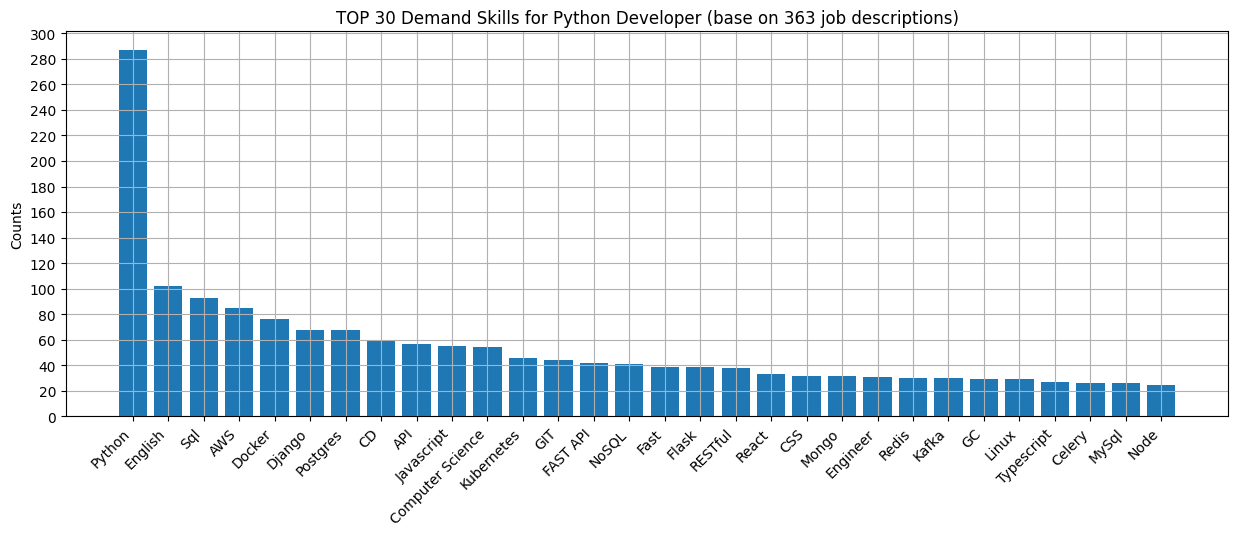

In [9]:
from config import POSITION

# get top 20 demands
top_skills = skills_df.iloc[:30, :]

plt.figure(figsize=(15, 5))
plt.bar(top_skills.tools, top_skills["count"])

plt.title(f"TOP {top_skills.shape[0]} Demand Skills for {POSITION} Developer (base on {df.shape[0]} job descriptions)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Counts")
plt.yticks(range(0, top_skills["count"].max() + 20, 20))
plt.grid(True)

# save diagram
no_filters = os.path.join(diagrams, "no_filters")
plt.savefig(os.path.join(no_filters, f"skills_{uuid.uuid4()}.jpg"))

plt.show()

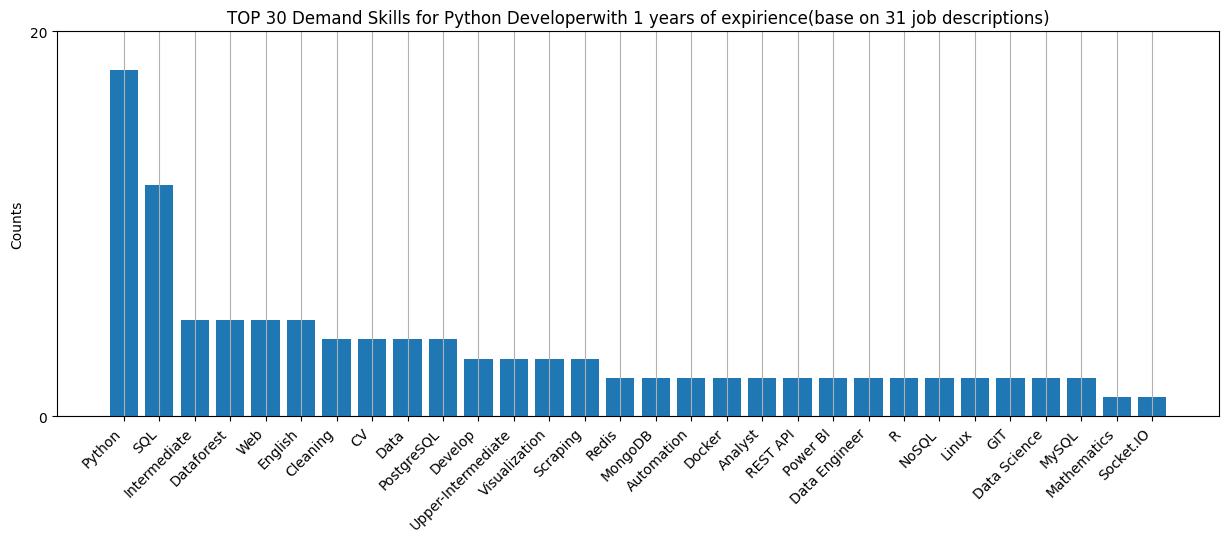

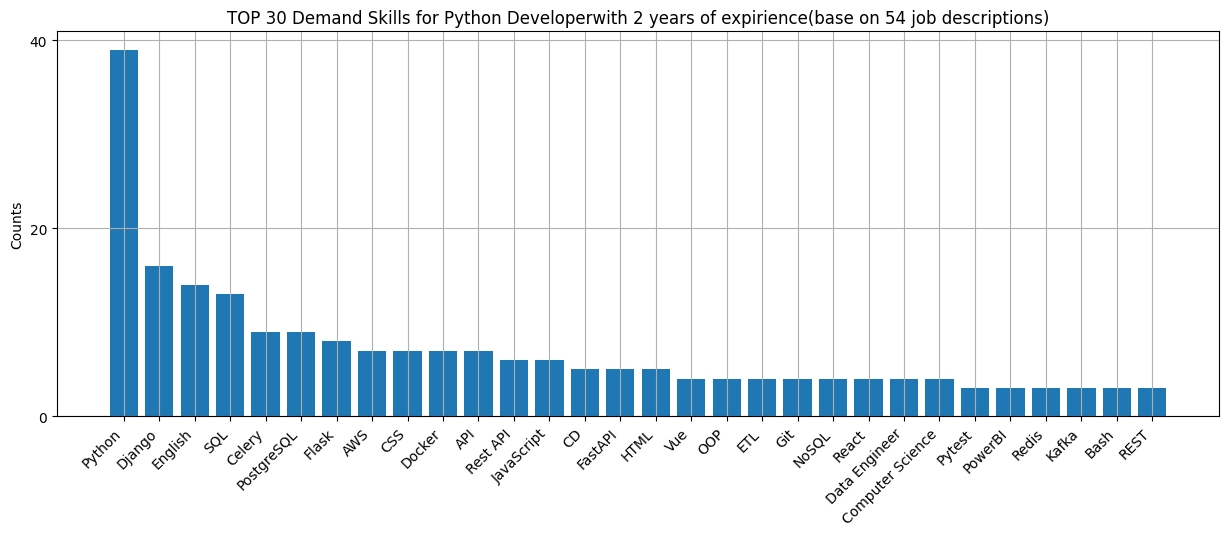

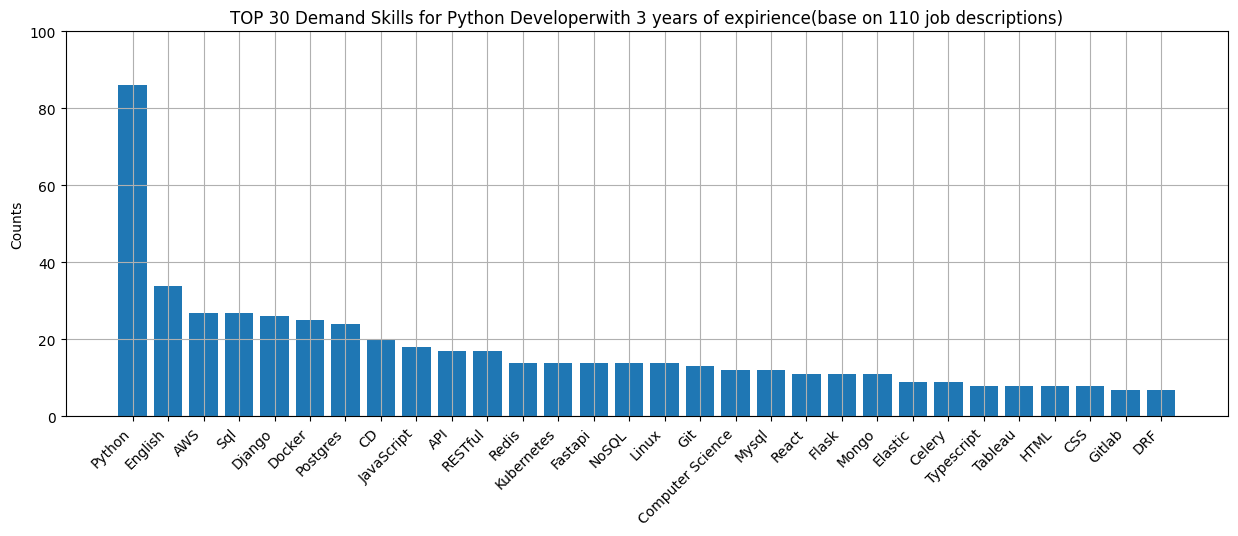

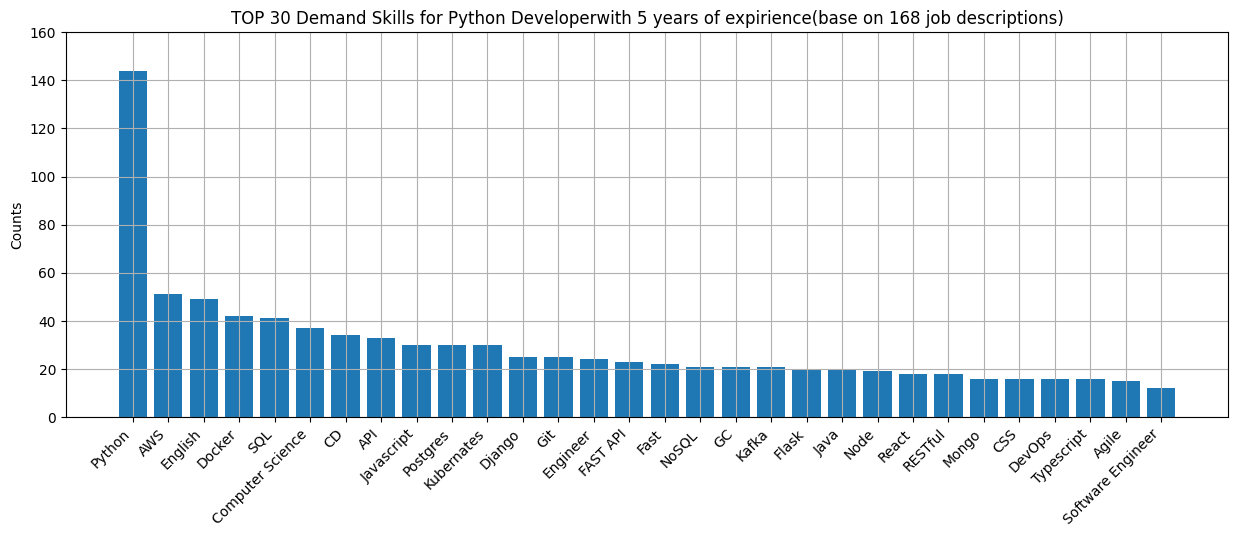

In [10]:
# group by year of expirience
grouped = df.groupby("year_of_exp")


# create a bar plot for each year of exprience
# and we are not using subplots() because we want to save each plot seperatly
for i, (year, data) in enumerate(grouped):
   
    all_skills = pd.Series(data['tools'].sum())
    # Count the occurrences of each tool
    skill_counts = all_skills.value_counts()
    
    skills = removing_duplicates(skill_counts)
    # Create DataFrame from dictionary
    skills = pd.DataFrame({'tools': list(skills.keys()), 'count': list(skills.values())})
    # Sort DataFrame by count in descending order
    skills = skills.sort_values(by='count', ascending=False)
    
    top_skills = skills.iloc[:30, :]
    
    plt.figure(figsize=(15, 5))
    plt.bar(top_skills.tools, top_skills["count"])
    
    plt.title((
        f"TOP {len(top_skills)} Demand Skills for {POSITION} Developer"
        f"with {year} years of expirience(base on {len(data)} job descriptions)"
    ))
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Counts")
    plt.yticks(range(0, top_skills["count"].max() + 20, 20))
    plt.grid(True)
   
    # save diagram
    by_year = os.path.join(diagrams, f"{year}_year_of_exp")
    os.makedirs(by_year, exist_ok=True)
    plt.savefig(os.path.join(by_year, f"skills_{uuid.uuid4()}.jpg"))

    plt.show()
    plt.close()

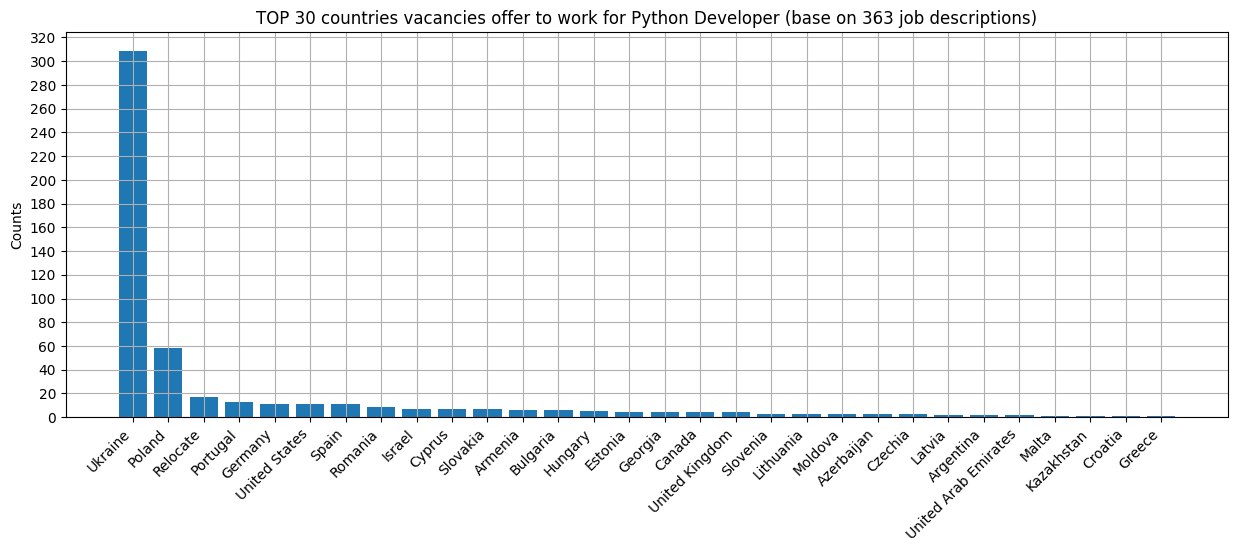

In [10]:
# See djinni Job Locations
countries = pd.Series(df.country.sum())
countries = countries.value_counts()

# get top 20 countries job vacancies offering
top_countries = countries[:30]

plt.figure(figsize=(15, 5))
plt.bar(top_countries.index, top_countries)

plt.title(f"TOP {len(top_countries)} countries vacancies offer to work for {POSITION} Developer (base on {df.shape[0]} job descriptions)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Counts")
plt.yticks(range(0, countries.max() + 20, 20))
plt.grid(True)
plt.show()

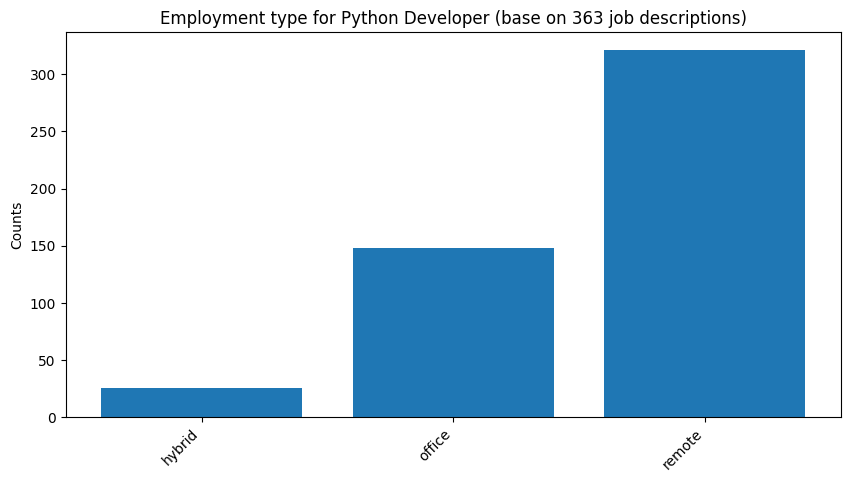

In [96]:
# See djinni employment type
empl_count = df[["hybrid", "office", "remote"]].sum()

plt.figure(figsize=(10, 5))
plt.bar(empl_count.index, empl_count)

plt.title(f"Employment type for {POSITION} Developer (base on {df.shape[0]} job descriptions)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Counts")
plt.show()

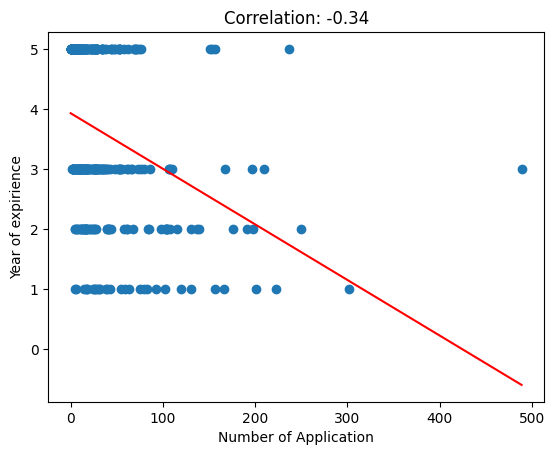

In [15]:
# See the correlation between year of expirience and number of applications
# either year of expirience increases number of application or not.

x, y = df["num_applications"], df["year_of_exp"]
plt.scatter(x, y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
plt.title(f"Correlation: {round(x.corr(y), 2)}")
plt.ylabel("Year of expirience")
plt.xlabel("Number of Application")
plt.show()

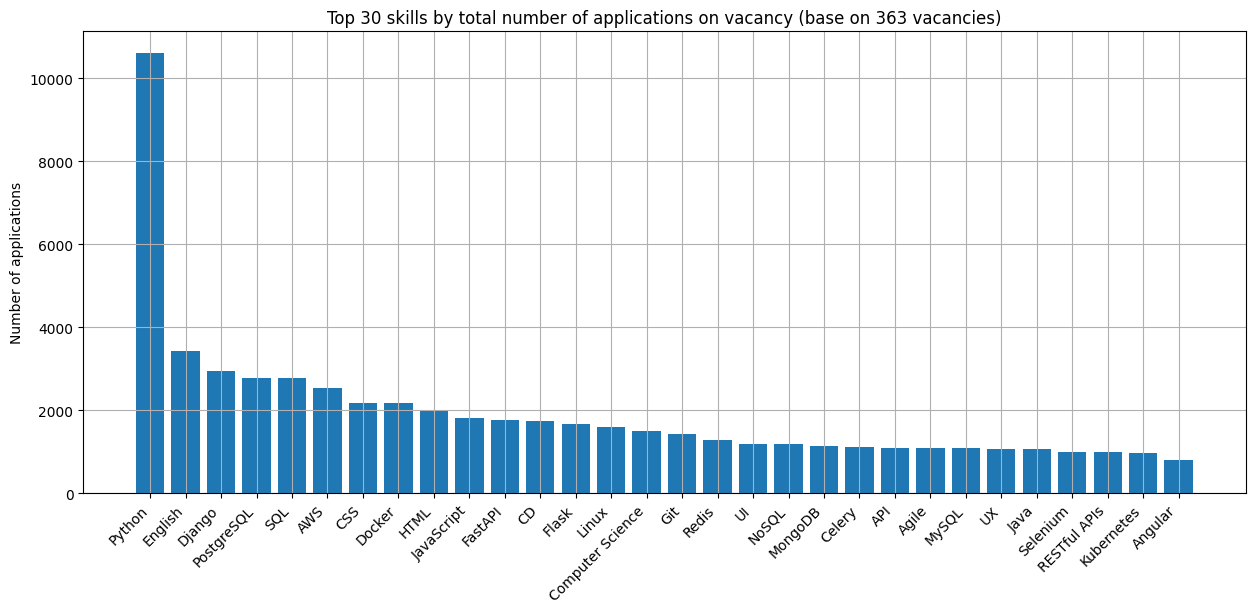

In [36]:
# Show top skills by each skill total number of applications on vacancy
skills = df.explode("tools")

skill_application = skills.groupby("tools")["num_applications"].sum().reset_index()
skills = skill_application.sort_values(by="num_applications", ascending=False)
top_skills = skills.iloc[:30, :]

plt.figure(figsize=(15, 6))
plt.bar(top_skills["tools"], top_skills["num_applications"])

plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of applications")
plt.title(f"Top {top_skills.shape[0]} skills by total number of applications on vacancy (base on {df.shape[0]} vacancies)")
plt.grid(True)

by_applications = os.path.join(diagrams, "by_applications")
plt.savefig(os.path.join(by_applications, f"skills_{uuid.uuid4()}.jpg")

plt.show()

In [11]:
# loading
df.to_csv("../jobs.csv")